Se cargan las librerias necesarias y se extra los datos de la imagen. Este presenta 1 espectro de
ciencia sin ningún ruido particular.

In [55]:
#Tratamiento de filesystem
#import os
#import sys
#sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
##%load_ext autoreload
##%autoreload 2
import Recursos
#%autoreload 1

#Tratamientos de datos
import numpy as np
#Gráficos
import matplotlib.pyplot as plt
import scipy.stats as stats
#Modelos
from sklearn.mixture import GaussianMixture
NOMBRE_IMG1 = 'A4762-HD166734.fits' #posee un espectro celeste
datos, clusters = Recursos.getInfo(NOMBRE_IMG1)
#datos = Recursos.normalize_MinMax_2d(datos) #problema_no_se_ejecuta
Y = np.sum(datos, axis=0) #sumariza los pixels en el eje x
x = np.arange(Y.size)

In [18]:
def graficarInfo(img,x,Y):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
    ax1.imshow(img, cmap='gray')
    ax1.set_aspect('auto')
    ax2.plot(x,Y)
    ax1.set_xlabel(NOMBRE_IMG1)
    ax2.set_xlabel("sumarización")
    plt.show()

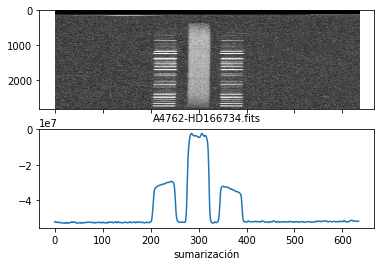

In [19]:
graficarInfo(datos,x,Y)

In [ ]:
import cv2
import scipy.ndimage as ndimage
b = ndimage.filters.median_filter(datos,size=8)
#graficar_imgs(datos,b)

In [ ]:
datos_fil = Recursos.normalize_MinMax_2d(b)
Y_fil = np.sum(datos_fil, axis=0) #sumariza los pixels en el eje x
graficarInfo(datos_fil,x,Y_fil)

In [20]:
def modelo_gmm(datos, clusters, nro_iters):
    #Se configura el modelo
    gmm = GaussianMixture(
    n_components=clusters, #agregar cantidad total: *3
    covariance_type='full',
    n_init= nro_iters)
    #datosNormImg.shape = (datosNormImg.shape[0],1)
    #Se estima el modelo
    gmm.fit(datos)
    #Se predice el cluster para cada punto de la imagen
    #etiquetasClusters = gmm.predict(datosNormImg)
    print("Datos del modelo")
    print("centroides")
    print(gmm.means_)
    print("%")
    print(gmm.weights_)
    print("std")
    print(np.sqrt(gmm.covariances_))
    return gmm

(635,)
Datos del modelo
centroides
[[-52142368.58619651]
 [ -4023461.89340257]
 [-34174829.44564947]]
%
[0.75377639 0.06262036 0.18360326]
std
[[[ 326070.25887963]]

 [[1205704.47737026]]

 [[6898897.32758022]]]


<function matplotlib.pyplot.show(*args, **kw)>

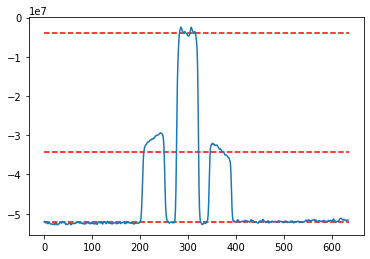

In [21]:
print(Y.shape)
modelo = modelo_gmm(Y.reshape(-1,1), clusters*3, 500)
plt.plot(x,Y)
plt.hlines(modelo.means_,0, x.size,colors='r',linestyles='dashed')
plt.show

Consejo:
El problema es que estás entrenando mal los modelos. Fijate que como respuesta el modelo te responde con 3 centros sobre el eje y, pero vos los querés sobre el eje x. Les estás dando todos los "datos" como si fueran desordenados, y en realidad a vos te interesa modelar una función continua con los datos. Es una cuestión de cómo se los das. Lo que tendrías que hacer, entonces, es utilizar los valores y como "cantidad" de datos para el valores específico en el eje x.  -->PREG: CON CANTIDAD SE REFIERE A BUSCAR PARA UN VALOR EN LA FUNCION CUAL ES SU POSICION Y CUANTO SE REPITE? EN LOS SIGUIENTES PROBÉ ALGO SIMILAR PERO NO LE ENCUENTRO SENTIDO. O SEA ENTIENDO QUE DESEO QUE LOS DATOS ESTEN SOBRE EL EJE X, ENTONCES REINVERTIRIA EN VALORES SOBRE EL EJE ACTUAL NO? YA QUE LA FUNCION ES DE UN TAMAÑO DE 635 CON VALORES EN EJE Y,REINVERTIRIA ESTO VERDAD? ASI AL PASARLE AL MODELO DARIA RESULTADOS SOBRE EL EJE X?

Por ejemplo si tenés la serie "1, 5, 2, 1"  deberías generar un dataset con "1, 2, 2, 2, 2, 2, 3, 3, 4".  Entonces ahora la media va a estar alrededor del 2, que es lo que querías. 
-->PREG: ESTO ES PARA GRAFICAR CON LA MEDIA SI GENERARIA ANTES VALORES ALEATORIOS PARA CUMPLA ESAS CONDICIONES. AGREGUE UN MODULO PARA ESTO AL FINAL.
Podés multiplicar por un coeficiente menor para no generar exactamente la cantidad de datos, así no queda tan grande el dataset nuevo.

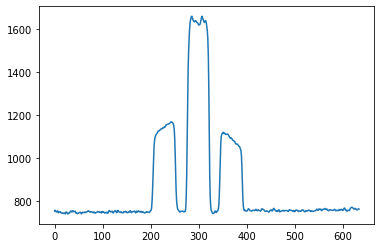

In [94]:
#normalizacion 2d
def normalize(vector):
    v = np.array(vector.copy(), dtype=np.float64)
    return(v - v.min()) / (v.max() - v.min())
    #pixels -= pixels.min()
    #pixels /= (pixels.max() - pixels.min())

pixeles = normalize(datos)
Y = np.sum(pixels, axis=0) #sumariza los pixels en el eje x
plt.plot(Y)


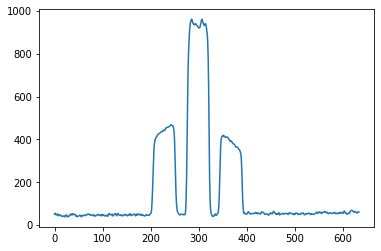

In [103]:
Y_nuevo = Y.copy()
Y_nuevo -= 700  #se reduce valor en y para no generar una enorme cantidad de valores en pasos posteriores
plt.plot(Y_nuevo)

Se generan datos de acuerdo al siguiente criterio: dada la función que contiene 635 elementos se considera al rango de valores en el eje x como el nuevo valor en el eje y. De modo que cada valor en el eje y de la función original indique la cantidad de datos a generar.

In [111]:
nuevo_dataset = []   #nueva funcion
for i in range(Y_nuevo.size):
    #print(Y[i]) #valor decimal
    nuevos = np.ones( int(Y_nuevo[i])) *i   # genera tantos datos como diga Y[i]  con el valor i
    nuevo_dataset = np.append(nuevo_dataset, nuevos)   
print(nuevo_dataset.size)
print(nuevo_dataset.shape)

105825
(105825,)


In [ ]:
modelo_nuevo = modelo_gmm(nuevo_dataset.reshape(-1,1), clusters*3, 100)

#resultados modelo con 100 iteraciones
Datos del modelo
centroides
[[296.7623741 ]
 [532.76880197]
 [ 86.38886673]]
%
[0.82345036 0.10522373 0.07132591]
std
[[[55.8405285 ]]

 [[64.5548245 ]]

 [[55.02589954]]]


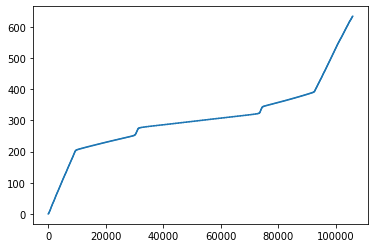

In [114]:
plt.plot(np.sort(nuevo_dataset))

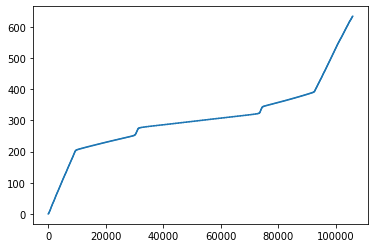

In [138]:
plt.plot(nuevo_dataset)

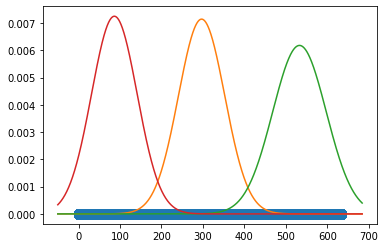

In [116]:
import scipy
#Get list of means and variances
mu = np.abs(modelo_nuevo.means_.flatten())
sd = np.sqrt(np.abs(modelo_nuevo.covariances_.flatten()))
num_components = 3
#Plotting
extend_window = 50  #this is for zooming into or out of the graph, higher it is , more zoom out
x_values = np.arange(nuevo_dataset.min()-extend_window, nuevo_dataset.max()+extend_window, 0.1) #For plotting smooth graphs
plt.plot(nuevo_dataset, np.zeros(nuevo_dataset.shape), linestyle='None', markersize = 10.0, marker='o') #plot the data on x axis

#plot the different distributions (in this case 2 of them)
for i in range(num_components):
    y_values = scipy.stats.norm(mu[i], sd[i])
    plt.plot(x_values, y_values.pdf(x_values))

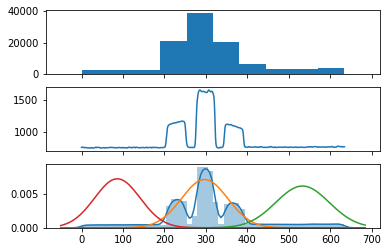

In [126]:
import seaborn as sns

fig,(ax1, ax2,ax4) = plt.subplots(nrows=3, ncols=1, sharex=True)
ax1.hist(nuevo_dataset)
ax2.plot(Y)
sns.distplot(nuevo_dataset)
for i in range(num_components):
    y_values = scipy.stats.norm(mu[i], sd[i])
    ax4.plot(x_values, y_values.pdf(x_values))
plt.show()

In [127]:
modelo_nuevo = modelo_gmm(nuevo_dataset.reshape(-1,1), clusters*3, 300)


Datos del modelo
centroides
[[296.7623741 ]
 [532.76880197]
 [ 86.38886673]]
%
[0.82345036 0.10522373 0.07132591]
std
[[[55.8405285 ]]

 [[64.5548245 ]]

 [[55.02589954]]]


In [128]:
modelo_nuevo = modelo_gmm(nuevo_dataset.reshape(-1,1), 6, 300)


Datos del modelo
centroides
[[366.99960731]
 [101.23466473]
 [518.87664841]
 [288.0181896 ]
 [229.20884783]
 [310.09501879]]
%
[0.18418847 0.08674075 0.12094318 0.20111707 0.20620834 0.20080219]
std
[[[16.90418754]]

 [[60.5360744 ]]

 [[70.98284564]]

 [[ 7.69103735]]

 [[15.96195481]]

 [[ 7.62884533]]]


In [129]:
mu = np.abs(modelo_nuevo.means_.flatten())
sd = np.sqrt(np.abs(modelo_nuevo.covariances_.flatten()))
num_components = 6

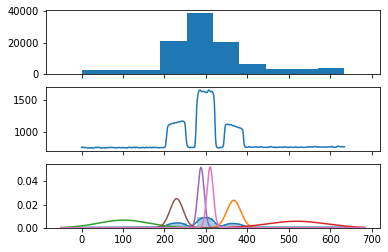

In [130]:
fig,(ax1, ax2,ax4) = plt.subplots(nrows=3, ncols=1, sharex=True)
ax1.hist(nuevo_dataset)
ax2.plot(Y)
sns.distplot(nuevo_dataset)
for i in range(num_components):
    y_values = scipy.stats.norm(mu[i], sd[i])
    ax4.plot(x_values, y_values.pdf(x_values))
plt.show()

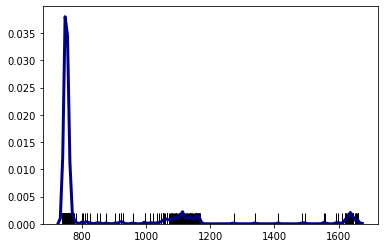

In [132]:
# Density Plot with Rug Plot
sns.distplot(Y, hist = False, kde = True, rug = True,
             color = 'darkblue', 
             kde_kws={'linewidth': 3},
             rug_kws={'color': 'black'})

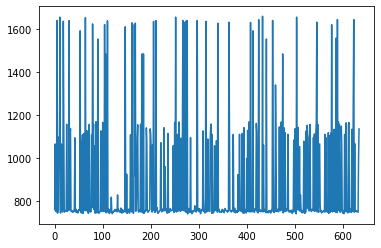

In [134]:
x = np.random.choice(Y, size=Y.size)
plt.plot(x)

# 2da parte

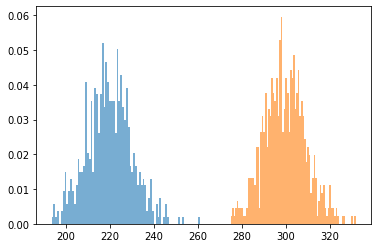

In [30]:
#EXTRA
# generar datos
cant = Y.size
np.random.seed(2)
x1 = np.random.normal(220, 10, size = cant)  #mu,std,size
x2 = np.random.normal(300, 10, size = cant)
data = [x1, x2]

def plot_hist(data):
    for x in data:
        plt.hist(x, bins = 80, density = True, alpha = 0.6)

plot_hist(data)

In [ ]:
n = []   #nueva funcion
for i in range(Y_nuevo.size):
    #print(Y[i]) #valor decimal
    nuevos = np.ones( int(Y_nuevo[i])) *i   # genera tantos datos como diga Y[i]  con el valor i
    n = np.append(nuevo_dataset, nuevos)   
print(n.size)
print(n.shape)